In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' # to print multiple outputs from the same cell
import math
import utils
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from operator import index
from collections import defaultdict
from scipy.stats import pearsonr
from datetime import datetime

In [2]:
users_df = pd.read_csv("dataset/users.csv")

# User Data Understanding and Preparation

In users.csv there are the following variables:
1. User Id: a unique identifier of the user
2. Statues Count: According to the teacher, this is the count of the tweets made by the user at the moment of data
crawling. According to [Twitter API docs](https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/user), this is the number of Tweets (including retweets) issued by the user, but not replies (according to Francesca Naretto); since tweets.csv inclues also users' replies note that **there is no link between the number of tweets for each user in tweets.csv and statuses_count**.
3. Lang: the user’s language selected
4. Created at: the timestamp in which the profile was created
5. Label: a binary variable that indicates if a user is a bot or a genuine user

In [3]:
users_df.info(verbose=True, show_counts=True, memory_usage= "deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11508 entries, 0 to 11507
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              11508 non-null  int64  
 1   name            11507 non-null  object 
 2   lang            11508 non-null  object 
 3   bot             11508 non-null  int64  
 4   created_at      11508 non-null  object 
 5   statuses_count  11109 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 2.5 MB


### Attribute type and quality

In the **user** dataset there are 6 columns:

1. The id **column** seems to be ok, all values are integer and there are not null values, we have to check possible duplicates
 
2. We have 1 null value in the **name** column, we also assume that the name could be a string, a number or a special character, the names are not necessarily unique, but maybe it's intresting to check the frequency distribution.

3. In the **lang** column we don't have null values, but we have to check whether there are problems in the pattern used to express the language, we expect a categorical attribute 

4. The **bot** column is numerical as expected (binary), we have to check whether all the numbers are 0 or 1

5. The attribute **created_at** has no null values, but we have to check the correctness of the date, both sintactic and semantic (not too far in the past or in the future)

6. The **status_count** column has 399 of null values, in the non-null values there would semm to be unexpected float

# 1. ID column

In [4]:
print("Number of total IDs:", len(users_df["id"]))
print("Number of unique IDs:", len(pd.unique(users_df["id"])))

Number of total IDs: 11508
Number of unique IDs: 11508


As said before one name is null. There are also duplicate names, but this isn't a surprising behaviour, as many people have the same names. By plotting the names' frequencies we can see that there aren't strange phenomena.

Renaming ID to user_id to avoid confusion.

In [5]:
users_df.rename(columns= {"id" : "user_id"}, inplace=True)

# 2. Name Column

Number of total names: 11508
Number of unique names: 11361
Number of total names = 11508 vs total name values that are not NA or empty = 11507
Number of total names = 11508 vs total name values that are NA or empty = 1


array([[<AxesSubplot: title={'center': 'frequencies'}>]], dtype=object)

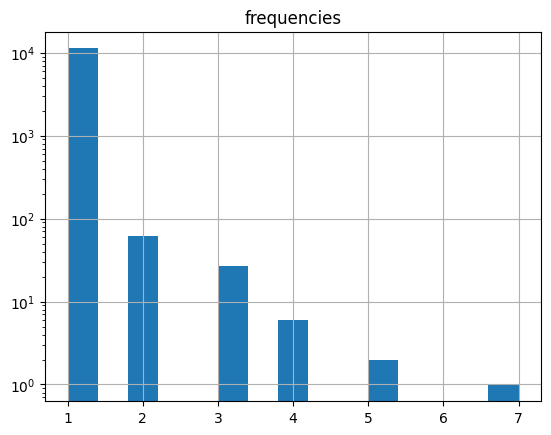

In [6]:
print("Number of total names:", len(users_df["name"]))
print("Number of unique names:", len(pd.unique(users_df["name"])))

freq = {}
for n in users_df['name']:
    if n in freq:
        freq[n] += 1
    else:
        freq[n] = 1

number_of_total_names = len(users_df["name"])
not_empty_or_missing_names = []
empty_or_missing_names = []
names_with_only_spaces = []

# iterate over all names looking for errors
for value in users_df["name"]:
    if pd.isna(value) or value == "": # name is nan or is_empty string
        empty_or_missing_names.append(value)
    if str(value).strip() == "":
            names_with_only_spaces.append(value)
    elif not(pd.isna(value) or value == ""):
        not_empty_or_missing_names.append(value)
        
print(f"Number of total names = {number_of_total_names} vs total name values that are not NA or empty = {len(not_empty_or_missing_names)}")
print(f"Number of total names = {number_of_total_names} vs total name values that are NA or empty = {len(empty_or_missing_names)}")

pd.DataFrame({"frequencies": [_ for _ in freq.values()]}).hist(
    column=["frequencies"], 
    log=True, 
    bins=utils.get_sturges_bins(len(freq.values()))
)

We don't see the 1 missing name to be of any significance. So we will just let it be for now. Now let's check the different languages in the "lang" column.

# 3. Language Column

In [7]:
pd.unique(users_df["lang"])  

array(['en', 'it', 'fr', 'ru', 'es', 'tr', 'en-gb', 'pt', 'nl', 'id',
       'zh-tw', 'ja', 'de', 'ko', 'en-AU', 'da', 'ar', 'en-GB',
       'Select Language...', 'zh-TW', 'zh-cn', 'pl', 'el', 'fil', 'sv',
       'xx-lc'], dtype=object)

The "lang" field is composed of [IETF language codes](https://en.wikipedia.org/wiki/IETF_language_tag). By selecting only the unique values it's possible to see that there are some erroneous values:
* "Select Language..." and "xx-lc" seems to be **default values**
* other values are not properly correct (e.g. "zh-cn" instead of "zh-CN")
We propose to check the most common language used by these 'erroneous values' users and provide them with a more fitting language attribute. This will be done after we have analysed the tweets data.

In [8]:
utils.repair_lang_attribute(users_df)
pd.unique(users_df["lang"])

array(['en', 'it', 'fr', 'ru', 'es', 'tr', 'en-GB', 'pt', 'nl', 'id',
       'zh-TW', 'ja', 'de', 'ko', 'en-AU', 'da', 'ar',
       'Select Language...', 'zh-CN', 'pl', 'el', 'fil-PH', 'sv', 'xx-lc'],
      dtype=object)

Since wrong values are just the 0.02% of the number of rows they are just dropped *(!!! the actual code in utils.py doesn't drop the default values)*, while the other values are mapped to the correct ones.

# 4. Bot Column

In [9]:
pd.unique(users_df["bot"])

array([1, 0])

As you can see from the users_df.info() function. The bot attribute is perfectly as expected, all non-null binary values.

With the unique function we validate that the bot values only consist of zeroes and ones.

# 5. Created_at Column

We observe that the created_at coloumn is recognized by pandas as an object, and not as a datetime as we would expect from this attribute. Clean created_at field, by converting string to datetime. We can also note that there are no users whose account was created before (after) the date of creation of the first tweet.

In [10]:
# parsing string to datetime obj
users_df["created_at"] = pd.to_datetime(users_df["created_at"])

before_time_users_df = users_df[users_df["created_at"] < datetime(2006,3,21,9,50,0)]
before_time_users_df.info()

# finding tweets created after dataset release
before_time_users_df = users_df[users_df["created_at"] > datetime(2022,9,29,11,0,0)]
before_time_users_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         0 non-null      int64         
 1   name            0 non-null      object        
 2   lang            0 non-null      object        
 3   bot             0 non-null      int64         
 4   created_at      0 non-null      datetime64[ns]
 5   statuses_count  0 non-null      float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 0.0+ bytes
<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         0 non-null      int64         
 1   name            0 non-null      object        
 2   lang            0 non-null      object        
 3   bot             0 non-null      int64         
 4  

No users are created before or after our tresholds. This is good.

# 6. Statuses_count Column

We expect the statuses count to be an integer, but pandas has interpreted it as a float. This is probably due to the presence of NaN values. Checking for NaN values.

In [11]:
users_df[users_df["statuses_count"].isna()]

,user_id,name,lang,bot,created_at,statuses_count
8,616225564,Anisha Williams,en,0,2017-06-25 15:49:36,NaN
20,1370348599,Robert Brown,en,0,2018-04-23 19:05:48,NaN
66,617369459,Sage Pennington,en,0,2017-06-26 18:50:48,NaN
77,2362195375,Delaine Nock,en,0,2019-02-28 05:35:38,NaN
110,2351047069,Tosha Pacitti,en,0,2019-02-21 03:14:40,NaN
...,...,...,...,...,...,...
11256,2352903248,Margherita Dass,en,0,2019-02-22 07:59:20,NaN
11321,2366095543,Annmarie Willoby,en,0,2019-03-02 20:53:35,NaN
11332,1176282888,Blanch Mobley,en,0,2018-02-15 17:38:55,NaN
11391,1175005345,Marna Lemley,en,0,2018-02-15 11:27:01,NaN


In [12]:
nan_status_count_users_df = users_df[users_df["statuses_count"].isna()]
list_of_humans = []
list_of_bots = []
for elem in nan_status_count_users_df["bot"]:
    if elem == 1:
        list_of_bots.append(elem)
    elif elem == 0:
        list_of_humans.append(elem)
    else:
        print("Didnt work")

print(f"Users with NaN values for statuses_count, consists of {len(list_of_humans)} humans and {len(list_of_bots)} bots")


Users with NaN values for statuses_count, consists of 399 humans and 0 bots


We have found 399 accounts of NaN values in the statuses_count column, where all of the accounts belong to humans.

In [13]:
Number_of_users_in_dataset_that_are_bots = users_df.groupby("bot").get_group(1)
Number_of_users_in_dataset_that_are_humans = users_df.groupby("bot").get_group(0)
total = len(Number_of_users_in_dataset_that_are_bots) + len(Number_of_users_in_dataset_that_are_humans)
print(f"Out of the {total} users in our dataset. {len(Number_of_users_in_dataset_that_are_humans)} are humans, and {len(Number_of_users_in_dataset_that_are_bots)} are bots.")
print(f"The dataset consists of {round(100*(len(Number_of_users_in_dataset_that_are_humans)/total),3)}% humans and {round(100*(len(Number_of_users_in_dataset_that_are_bots)/total),3)}% bots respectively.")
print(f"399 of our users are missing their statuses_count values. These humans consist of {round(100*(len(list_of_humans)/total),3)}% of our dataset.")
print(f"These users will be removed.")

Out of the 11508 users in our dataset. 5392 are humans, and 6116 are bots.
The dataset consists of 46.854% humans and 53.146% bots respectively.
399 of our users are missing their statuses_count values. These humans consist of 3.467% of our dataset.
These users will be removed.


We calculate these NaN values to effect 3.467% of all the human users. But we will remove them as we can calculate that the dataset is fairly balanced. Containing 46.854% humans and 53.146% bots. In a perfect world this ratio would be 1:1, but we can balance this later in our training sets should we need to.

In [14]:
users_df.drop(users_df[users_df["statuses_count"].isna()].index, inplace=True)
users_df.info(verbose=True, show_counts=True, memory_usage= "deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11109 entries, 0 to 11507
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         11109 non-null  int64         
 1   name            11108 non-null  object        
 2   lang            11109 non-null  object        
 3   bot             11109 non-null  int64         
 4   created_at      11109 non-null  datetime64[ns]
 5   statuses_count  11109 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 1.8 MB


The Dtype for the statuses_count is still float, even though the NaN values have been dropped. Will try to convert the remaining values to type int64.

In [15]:
users_df["statuses_count"] = users_df["statuses_count"].apply(np.int64)
users_df.info(verbose=True, show_counts=True, memory_usage= "deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11109 entries, 0 to 11507
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         11109 non-null  int64         
 1   name            11108 non-null  object        
 2   lang            11109 non-null  object        
 3   bot             11109 non-null  int64         
 4   created_at      11109 non-null  datetime64[ns]
 5   statuses_count  11109 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 1.8 MB


We should also make sure that our statuses_count columnn only contain numbers >= than 0.

In [16]:
users_df[users_df["statuses_count"] < 0]

,user_id,name,lang,bot,created_at,statuses_count


We verify that all our statuses_count values are positive or equal to zero. This is good.

### Distribution of variables and statistics
Let's study them!

## 3. Language Column

<AxesSubplot: xlabel='lang'>

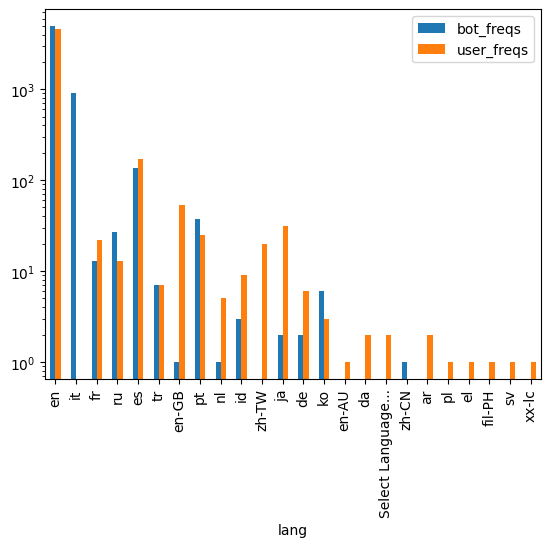

In [17]:
langs = pd.unique(users_df["lang"]) 
bot_freqs = []
user_freqs = []
for lang in langs:
    user_freqs.append(len(users_df.query(f"lang == '{lang}' & bot == 0")))
    bot_freqs.append(len(users_df.query(f"lang == '{lang}' & bot == 1")))
langs_df = pd.DataFrame({"lang": langs, "bot_freqs": bot_freqs, "user_freqs": user_freqs})
langs_df.plot.bar(x="lang", logy=True)

## 6. Statuses_count Column

array([[<AxesSubplot: title={'center': 'statuses_count'}>]], dtype=object)

array([<AxesSubplot: title={'center': '0'}>,
       <AxesSubplot: title={'center': '1'}>], dtype=object)

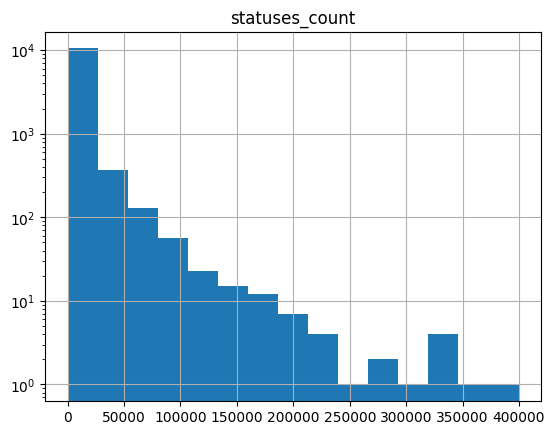

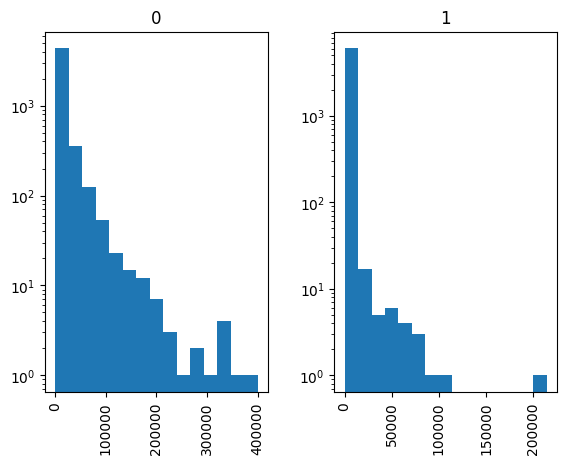

In [18]:
users_df.hist(
    column=["statuses_count"], 
    log=True, 
    bins=utils.get_sturges_bins(len(users_df["statuses_count"]))
)

users_df.hist(
    column=["statuses_count"], 
    by="bot", 
    log=True,
    bins=utils.get_sturges_bins(len(users_df["statuses_count"])) #FIX THIS: USES ALL THE SAMPLES, NOT JUST THE BOTS AND THE USERS
)

Performing outliers detection (via a boxplot) in the only numeric column we have in users dataframe: statuses_count

<AxesSubplot: >

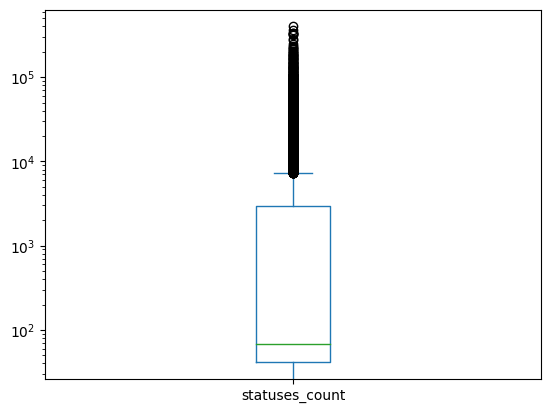

In [19]:
users_df.plot(
    kind="box",
    column="statuses_count",
    logy=True
)

By looking at the boxplot above, we notice the presence of outliers; hence, we replace them with the median.

In [20]:
whisker_lower_bound, whisker_upper_bound = utils.compute_whiskers(users_df["statuses_count"])
statuses_count_median = users_df["statuses_count"].median() 

users_df["statuses_count"].mask(users_df["statuses_count"] > whisker_upper_bound, statuses_count_median, inplace=True)

Let's see how our outliers removal has affected the distribution of statuses count variable

array([[<AxesSubplot: title={'center': 'statuses_count'}>]], dtype=object)

array([<AxesSubplot: title={'center': '0'}>,
       <AxesSubplot: title={'center': '1'}>], dtype=object)

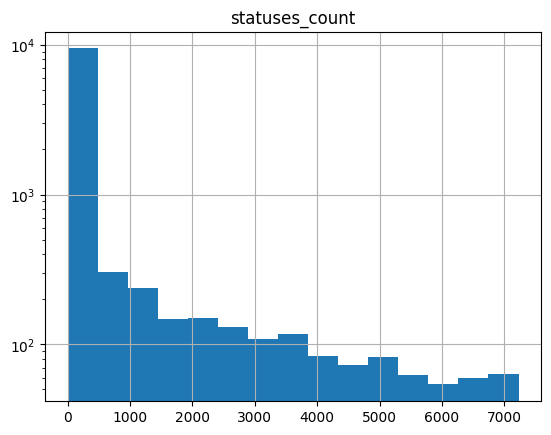

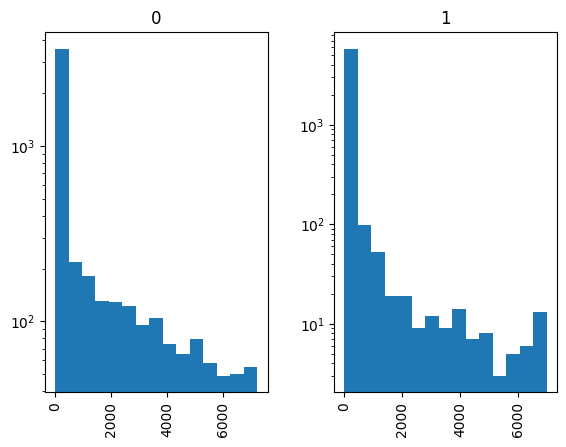

In [24]:
users_df.hist(
    column=["statuses_count"], 
    log=True, 
    bins=utils.get_sturges_bins(len(users_df["statuses_count"]))
)

users_df.hist(
    column=["statuses_count"], 
    by="bot", 
    log=True,
    bins=utils.get_sturges_bins(len(users_df["statuses_count"])) #FIX THIS: USES ALL THE SAMPLES, NOT JUST THE BOTS AND THE USERS
)

## User Data Quality Summary

In [21]:
users_df.info(verbose=True, show_counts=True)
users_df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11109 entries, 0 to 11507
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         11109 non-null  int64         
 1   name            11108 non-null  object        
 2   lang            11109 non-null  object        
 3   bot             11109 non-null  int64         
 4   created_at      11109 non-null  datetime64[ns]
 5   statuses_count  11109 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 607.5+ KB


,user_id,bot,statuses_count
count,1.110900e+04,11109.000000,11109.000000
mean,1.263638e+09,0.550545,486.128364
std,9.362909e+08,0.497461,1240.441286
min,6.780330e+05,0.000000,0.000000
25%,4.662898e+08,0.000000,41.000000
50%,1.127892e+09,1.000000,68.000000
75%,2.356956e+09,1.000000,81.000000
max,3.164942e+09,1.000000,7226.000000


In [22]:
Number_of_users_in_dataset_that_are_bots = users_df.groupby("bot").get_group(1)
Number_of_users_in_dataset_that_are_humans = users_df.groupby("bot").get_group(0)
total = len(Number_of_users_in_dataset_that_are_bots) + len(Number_of_users_in_dataset_that_are_humans)
print(f"Out of the {total} users in our dataset. {len(Number_of_users_in_dataset_that_are_humans)} are humans, and {len(Number_of_users_in_dataset_that_are_bots)} are bots.")
print(f"The dataset consists of {round(100*(len(Number_of_users_in_dataset_that_are_humans)/total),3)}% humans and {round(100*(len(Number_of_users_in_dataset_that_are_bots)/total),3)}% bots respectively.")
print(f"399 of our users are missing their statuses_count values. These humans consist of {round(100*(len(list_of_humans)/total),3)}% of our dataset.")
print(f"These users will be removed.")

Out of the 11109 users in our dataset. 4993 are humans, and 6116 are bots.
The dataset consists of 44.946% humans and 55.054% bots respectively.
399 of our users are missing their statuses_count values. These humans consist of 3.592% of our dataset.
These users will be removed.


After cleaning we are left with a "fairly" balanced and generalized dataset, that is ready for further use. The dataset contains approx. 45% human and 55% bot users. 

In [23]:
users_df.to_csv("./dataset/users_dataset_cleaned.csv",index=False)